## Global sea level changes in time series and linear regression analysis:

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      144 non-null    int64  
 1   CSIRO Adjusted Sea Level  134 non-null    float64
 2   Lower Error Bound         134 non-null    float64
 3   Upper Error Bound         134 non-null    float64
 4   NOAA Adjusted Sea Level   31 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 5.8 KB
None
Analyzing column: CSIRO Adjusted Sea Level


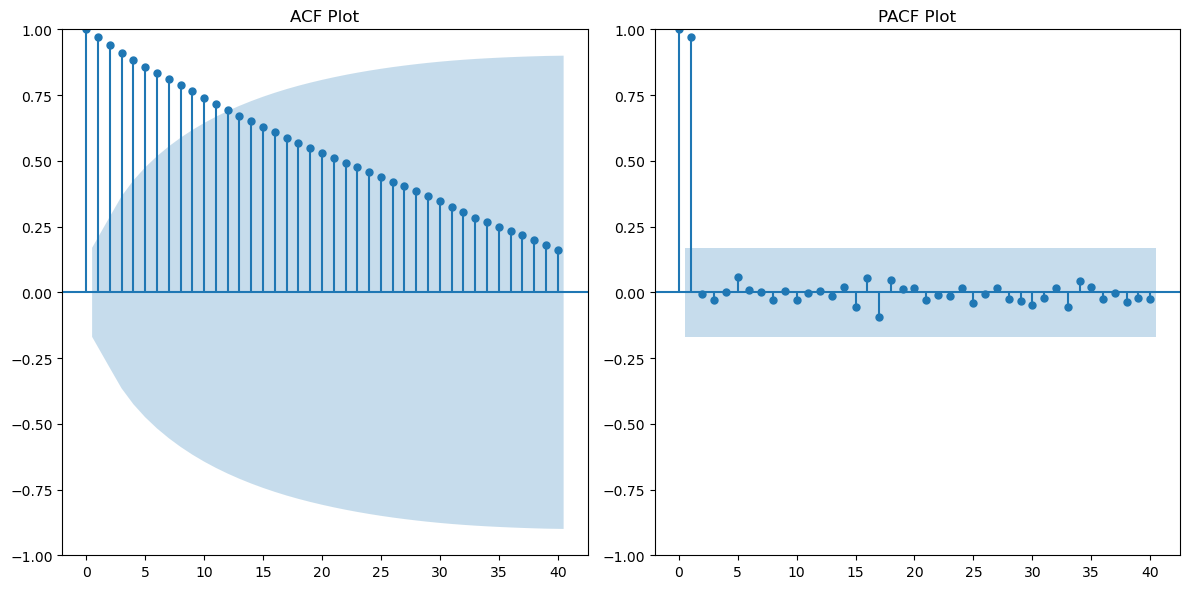


Linear Regression Results:
Coefficient: -0.06287653746247208
Intercept: 7.827693545284244
Mean Squared Error: 0.17730873055477633
R² Score: 0.9708980330536651


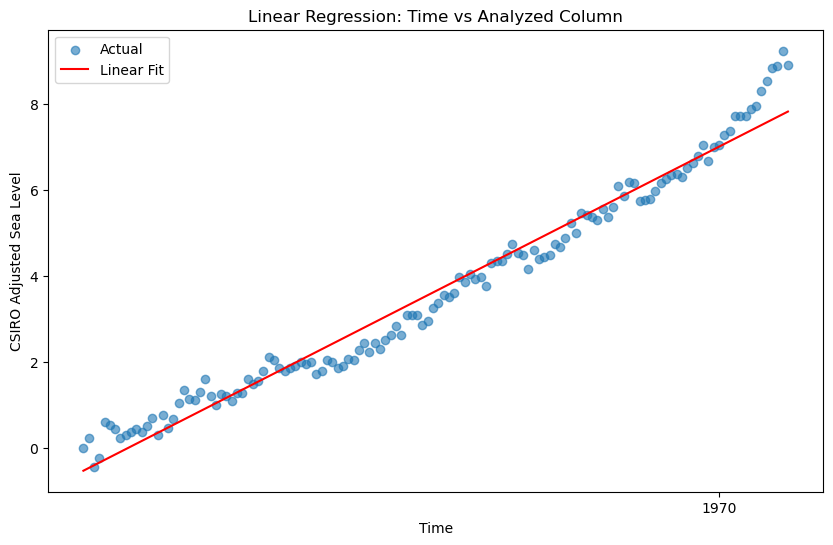

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
data = pd.read_csv("data/sea_data.csv")

# Inspect dataset and select numerical columns
print("Dataset Overview:")
print(data.info())

# Automatically detect a column to analyze (first numerical column after year)
# Assume 'Year' or time column is the index or first column
time_col = data.columns[0]
numerical_cols = data.select_dtypes(include=[np.number]).columns
if time_col in numerical_cols:
    numerical_cols = numerical_cols.drop(time_col)

# Choose the first numerical column for analysis
if len(numerical_cols) == 0:
    raise ValueError("No numerical columns available for analysis.")
analyzed_col = numerical_cols[0]
print(f"Analyzing column: {analyzed_col}")

# Preprocess dataset
data = data.dropna(subset=[time_col, analyzed_col])
data[time_col] = pd.to_datetime(data[time_col], errors='coerce')
data = data.set_index(time_col)

# Linear Regression
def linear_regression(data, time_col, analyzed_col):
    X = np.arange(len(data)).reshape(-1, 1)  # Use time index as a feature
    y = data[analyzed_col].values

    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

    # Metrics
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print("\nLinear Regression Results:")
    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(data.index, y, label="Actual", alpha=0.6)
    plt.plot(data.index, predictions, color='red', label="Linear Fit")
    plt.title("Linear Regression: Time vs Analyzed Column")
    plt.xlabel("Time")
    plt.ylabel(analyzed_col)
    plt.legend()
    plt.show()

# ACF and PACF Plots
def plot_acf_pacf(data, analyzed_col, lags=40):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(data[analyzed_col], lags=lags, ax=plt.gca())
    plt.title("ACF Plot")

    plt.subplot(122)
    plot_pacf(data[analyzed_col], lags=lags, ax=plt.gca())
    plt.title("PACF Plot")
    plt.tight_layout()
    plt.show()

# ARIMA Model
def arima_model(data, analyzed_col, order=(1, 1, 1)):
    model = ARIMA(data[analyzed_col], order=order)
    fit = model.fit()
    print(f"\nARIMA Model Summary:\n{fit.summary()}")

    # Forecast
    forecast_steps = 10
    forecast = fit.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='Y')[1:]
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    conf_int = forecast.conf_int()

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(data[analyzed_col], label="Actual")
    plt.plot(forecast_series, label="Forecast", color='red')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title("ARIMA Forecast")
    plt.xlabel("Time")
    plt.ylabel(analyzed_col)
    plt.legend()
    plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decomposition(data, analyzed_col, model='additive'):
    # Ensure the time index has a proper frequency
    data = data.copy()
    data = data.asfreq('Y')  # Set frequency to yearly ('Y'). Change if needed.

    # Decompose the time series
    decomposition = seasonal_decompose(data[analyzed_col], model=model)
    decomposition.plot()
    plt.suptitle("Seasonal Decomposition of Time Series", fontsize=14)
    plt.show()

# Fix for decomposition
plot_acf_pacf(data, analyzed_col)
linear_regression(data, time_col, analyzed_col)
